In [1]:
from astroquery.mast import Observations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
obs_table = Observations.query_criteria(obs_collection=['Kepler'],
                                        objectname="Kepler 12",
                                        dataproduct_type="timeseries",
                                        radius=0)

In [3]:
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str10,int64,str6,str36,str13,float64,float64,float64,float64,float64,str7,str6,float64,float64,str1,str18,float64,str6,str15,str2,str6,str6,int64,str6,str112,str109,str108,str6,bool,float64,str7,str10,str10,str10,float64
timeseries,2,Kepler,kplr011804465_lc_Q111111110111011101,kplr011804465,286.24343,50.04038,54953.0375,56423.50069444445,1800.0,OPTICAL,KEPLER,418400000000.0,905000000000.0,--,Kepler Key Project,--,Kepler,William Borucki,EX,Kepler,Kepler,--,Kepler,POLYGON ICRS 286.23997011 50.04260200 286.23997044 50.03815800 286.24688956 50.03815800 286.24688989 50.04260200,http://archive.stsci.edu/missions/kepler/previews/0118/011804465/kplr011804465-2013011073258_llc_bw_large.png,http://archive.stsci.edu/missions/kepler/lightcurves/0118/011804465/kplr011804465_lc_Q111111110111011101.tar,PUBLIC,--,5885.0,science,9000185756,9000199584,9000199584,0.0
timeseries,2,Kepler,kplr011804465_sc_Q003313330333000000,kplr011804465,286.24343,50.04038,54953.0375,56423.50069444445,60.0,OPTICAL,KEPLER,418400000000.0,905000000000.0,--,Kepler Key Project,--,Kepler,William Borucki,EX,Kepler,Kepler,--,Kepler,POLYGON ICRS 286.23997011 50.04260200 286.23997044 50.03815800 286.24688956 50.03815800 286.24688989 50.04260200,http://archive.stsci.edu/missions/kepler/previews/0118/011804465/kplr011804465-2011303113607_slc_bw_large.png,http://archive.stsci.edu/missions/kepler/lightcurves/0118/011804465/kplr011804465_sc_Q003313330333000000.tar,PUBLIC,--,5885.0,science,9000208864,9000199585,9000199585,0.0


In [1]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from astropy.constants import R_jup
import astropy.units as u


In [2]:
eat = NasaExoplanetArchive.get_confirmed_planets_table()

In [48]:
eat[(eat["pl_radj"]>.25 * R_jup) & 
    (eat["pl_orbeccen"]>.5) & 
    (eat["pl_orbper"]<20 * u.d) &
    (eat["pl_kepflag"]==1)
   ]

pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densn,pl_ttvflag,pl_kepflag,pl_k2flag,ra_str,dec_str,ra,st_raerr,dec,st_decerr,st_posn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,NAME_LOWERCASE,sky_coord
,,,,,,d,d,d,d,,AU,AU,AU,AU,,,,,,,deg,deg,deg,deg,,jupiterMass,jupiterMass,jupiterMass,jupiterMass,,,jupiterRad,jupiterRad,jupiterRad,jupiterRad,,,,,,,,,,,,deg,,deg,,,pc,pc,pc,pc,,mag,mag,mag,,,,,K,K,K,K,,solMass,solMass,solMass,solMass,,solRad,solRad,solRad,solRad,,,,,,"deg,deg"
str27,str1,str29,str29,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,str14,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,str14,str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,str11,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str10,str44,str26,object
Kepler-75,b,Kepler-75 b,Transit,0,1,8.8849116,3.4e-06,-3.4e-06,0.0,6,0.0818,0.0012,-0.0012,0.0,3,0.57,0.01,-0.01,0,3,89.12,0.51,-0.64,0.0,3,10.1,0.4,-0.4,0.0,3,Mass,1.05,0.03,-0.03,0.0,5,11.0,0.8,-0.9,0,3,0,1,0,19h24m33.02s,+36d34m38.6s,291.137593,1.9e-05,36.577386,1.7e-05,2,855.5,19.1,-19.1,0.0,4,15.264,0.0,0.0,Kepler-band,15.179,--,0,5200.0,100.0,-100.0,0.0,8,0.91,0.04,-0.04,0.0,4,0.89,0.02,-0.02,0.0,8,1,2015-01-29,Kepler,kepler-75b,"291.137593,36.577386"
Kepler-427,b,Kepler-427 b,Transit,0,1,10.290994,1.1e-06,-1.1e-06,0.0,5,0.091,0.01,-0.01,0.0,2,0.57,--,--,1,2,89.5,0.45,-0.45,0.0,2,0.29,0.09,-0.09,0.0,2,Mass,1.23,0.21,-0.21,0.0,4,0.16,0.14,-0.14,0,2,0,1,0,19h13m01.10s,+43d42m17.5s,288.25458,1.7e-05,43.704868,1.7e-05,2,1100.0,150.0,-150.0,0.0,4,14.42,0.02,0.0,V (Johnson),14.196,--,0,5800.0,70.0,-70.0,0.0,7,0.96,0.06,-0.06,0.0,3,1.35,0.2,-0.2,0.0,7,1,2014-10-03,Kepler,kepler-427b,"288.25458,43.704868"
KOI-12,b,KOI-12 b,Transit,0,1,17.85523,1e-06,-1e-06,0.0,5,0.0,0.0,0.0,0.0,1,0.72,--,--,0,2,88.95,0.2,-0.2,0.0,2,5.32,6.11,-6.11,0.0,2,Mass,1.54,0.45,-0.45,0.0,4,--,--,--,0,0,0,1,0,19h49m48.90s,+41d00m39.6s,297.453731,1.7e-05,41.010991,1.7e-05,2,403.99,4.42,-4.42,0.0,4,11.353,0.0,0.0,Kepler-band,11.253,--,0,6820.0,120.0,-120.0,0.0,7,1.82,1.64,-1.64,0.0,3,1.75,0.51,-0.51,0.0,7,1,2018-04-26,Kepler,koi-12b,"297.453731,41.010991"


In [17]:
from lightkurve import search_lightcurvefile, LightCurveCollection
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median

In [3]:
import numpy as np

In [4]:
lclist = search_lightcurvefile("KOI-12", cadence="short",)
lclist

SearchResult containing 50 data products.

 target_name                      productFilename                                 description              distance
------------- ------------------------------------------------------- ------------------------------------ --------
kplr005812701                    kplr005812701-2009131110544_slc.fits  Lightcurve Short Cadence (CSC) - Q0      0.0
kplr005812701                    kplr005812701-2009201121230_slc.fits  Lightcurve Short Cadence (CSC) - Q2      0.0
kplr005812701                    kplr005812701-2009231120729_slc.fits  Lightcurve Short Cadence (CSC) - Q2      0.0
kplr005812701                    kplr005812701-2009259162342_slc.fits  Lightcurve Short Cadence (CSC) - Q2      0.0
kplr005812701                    kplr005812701-2009291181958_slc.fits  Lightcurve Short Cadence (CSC) - Q3      0.0
kplr005812701                    kplr005812701-2009322144938_slc.fits  Lightcurve Short Cadence (CSC) - Q3      0.0
kplr005812701                

In [5]:
lcs = lclist.download_all()

In [22]:
lcc = [x.get_lightcurve("PDCSAP_FLUX") for x in lcs]
LCC = [FlareLightCurve(time=LC.time, flux=LC.flux, flux_err=LC.flux_err, cadenceno=LC.cadenceno) for LC in lcc]

In [23]:
for LC in LCC:
    flares = LC.detrend("savgol").find_flares().flares
    with open("res.csv", "a") as f:
        flares.to_csv(f, index=False)

Found 1 candidate(s) in the (0,14233) gap.
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
Found 0 candidate(s) in the (0,17532) gap.
Found 0 candidate(s) in the (17532,41816) gap.
Found 1 candidate(s) in the (0,33929) gap.
Found 0 candidate(s) in the (33929,43361) gap.
Found 0 candidate(s) in the (0,35138) gap.
Found 0 candidate(s) in the (35138,38271) gap.
Found 1 candidate(s) in the (0,10542) gap.
Found 0 candidate(s) in the (10542,29611) gap.
Found 0 candidate(s) in the (29611,43093) gap.
Found 1 candidate(s) in the (0,43976) gap.
Found 2 candidate(s) in the (0,38005) gap.
Found 1 candidate(s) in the (0,45419) gap.
Found 0 candid

In [109]:
flcd = LCC[45].detrend("savgol")

(1542.4, 1542.6)

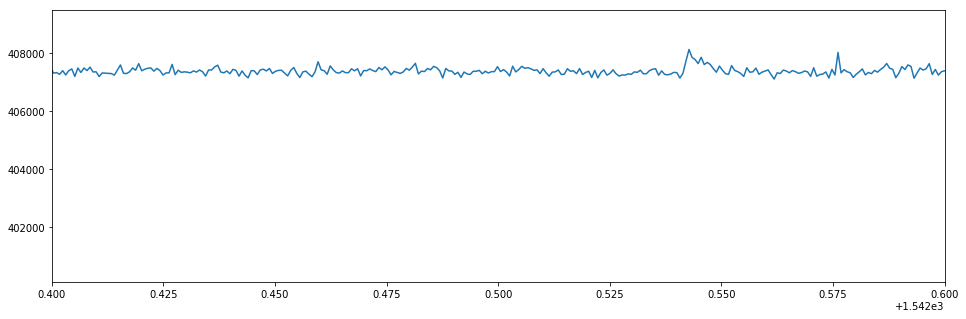

In [114]:
plt.figure(figsize=(16,5))
plt.plot(flcd.time, flcd.detrended_flux)
plt.xlim(1542.4,1542.6)

In [7]:
LC = lcc[0]
LC.flux[:] = LC.flux/np.nanmedian(LC.flux)
lcc[-1].flux[:] += lcc[-1].flux + 1.
lcc[-2].flux[:] += lcc[-2].flux + 1.
for lc in lcc[1:]:
    lc.flux = lc.flux/np.nanmedian(lc.flux)
    LC = LC.append(lc)

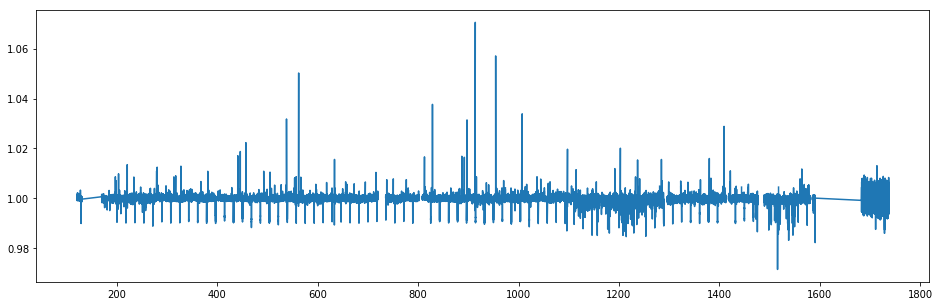

In [8]:
plt.figure(figsize=(16,5))
plt.plot(LC.time, LC.flux)
#plt.xlim(456.8,457)

In [12]:
FLC = FlareLightCurve(time=LC.time, flux=LC.flux, flux_err=LC.flux_err)

In [13]:
FLCd = FLC.detrend("savgol", window_length=15)

In [18]:
itmed = find_iterative_median(FLCd)

In [21]:
FLCd.detrended_flux

array([1.0000887 , 0.99997795, 1.0001796 , ..., 1.0047519 , 1.0013777 ,
       0.9994352 ], dtype=float32)

In [55]:
from altaipony.lcio import from_mast

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [97]:
flc = from_mast("KOI-12", cadence="short", mission="Kepler", c=4)

/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/lightkurve/search.py:181: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)
0% (147/45600) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (147/45600) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:56: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr005812701_sc_Q103333333333333332/kplr005812701-2010019161129_slc.fits' mode='rb' closefd=True>
  return _from_mast_Kepler(targetid, c, **kwargs)


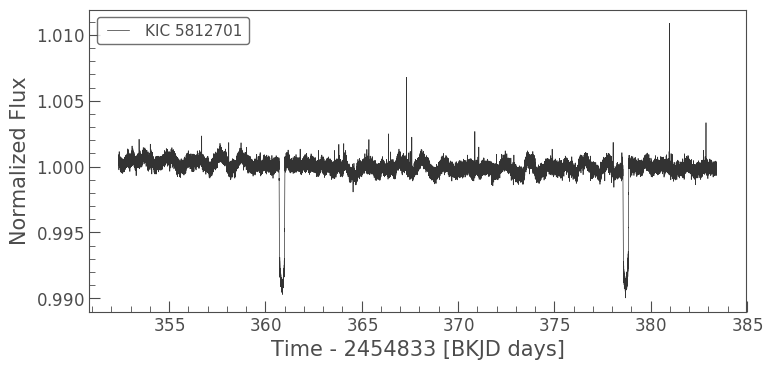

In [98]:
flc.plot()

In [99]:
flcd = flc.detrend("savgol")

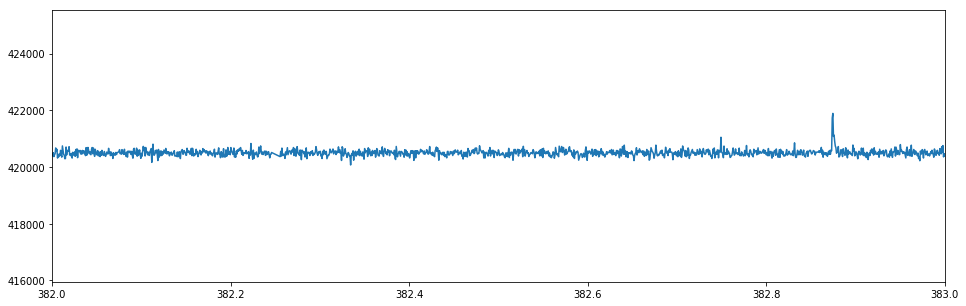

In [103]:
plt.figure(figsize=(16,5))
plt.plot(flcd.time, flcd.detrended_flux)
plt.xlim(382, 383);

In [102]:
flcd.find_flares().flares


Found 1 candidate(s) in the (0,45419) gap.
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop
0,0.00332,390671,390676,0.59554,0.027952,44624,44629,45419.0,382.873989,382.877394
